## 1.6.X Stereo Calibration 

### import  libraries

In [1]:
# for vscode
#%matplotlib qt

In [2]:
# for jupyter notebook

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

%matplotlib notebook

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 
from typing import Sequence
from calib_lib import *
DECIMALS = 2  # how many decimal places to use in print


In [4]:
F = 16                                       # focal length( in mm )
image_size = np.array([11,7])               # sensor size(in pixels)
PX= image_size[0]/2.0                       # principal point x-coordinate
PY= image_size[1]/2.0                       # principal point y-coordinate
IMAGE_HEIGTH = image_size[1]
IMAGE_WIDTH = image_size[0]
THETA_X = 0                                 # roll angle
THETA_Y = 0                                 # pitch angle
THETA_Z = 0                         # yaw angle


# camera Right
THETA_X_R = 0                                 # roll angle
THETA_Y_R = 0                                 # pitch angle
THETA_Z_R= 0                                 # yaw angle
# camera Left
THETA_X_L = 0                                 # roll angle
THETA_Y_L = 0                                 # pitch angle
THETA_Z_L= 0                                 # yaw angle

C_L = np.array([0,0,4])                     # camera centre
C_R = np.array([50,0,4])

chess_dimx,chess_dimy = (8,6)
chess_sq_size = 25


In [5]:
world_pts = create_chessboard(chess_dimx,chess_dimy,chess_sq_size)
X = get_chessboard_rot_trans(world_pts,rx = THETA_X,ry = THETA_Y,rz = THETA_Z,tx = 25,ty = 0,tz  = 400)

In [6]:
x_arr_L, X_arr_L, E_L = get_image_points(X,PX,PY,thetax=THETA_X_L,thetay = THETA_Y_L,thetaz = THETA_Z_L,trans_x= -C_L[0],trans_y= -C_L[1],trans_z= -C_L[2],F = F)

X_h_L = to_homogeneus_arr(X_arr_L)
x_h_L = to_homogeneus_arr(x_arr_L)

P_n_L = DLT(x_h_L,X_h_L)

print("Camera Matrix:\n",P_n_L)

n_points = X_h_L.shape[0]
xEst_L = np.zeros((n_points,2))

for j in range(n_points):
    X_pts = to_homogeneous(X_arr_L[j])
    x_aux  = np.dot(P_n_L,X_pts)
    xEst_L[j,:] = to_inhomogeneous(x_aux)
    
err_list_L = np.sqrt(np.mean(np.sum(np.square(x_arr_L-xEst_L), 1)))

print("Geometric error:",err_list_L)

Camera Matrix:
 [[-9.98069586e+00  2.12357280e-13 -2.13080415e+00 -5.06300563e+02]
 [-1.23420728e-13 -9.98069586e+00 -5.93684703e+00  1.51016104e+03]
 [-3.16998113e-14 -2.00393361e-14  1.00000000e+00 -6.47022222e+02]]
Geometric error: 1.618462455858553e-13


In [7]:
x_arr_R, X_arr_R, E_R = get_image_points(X,PX,PY,thetax = THETA_X_R,thetay = THETA_Y_R, thetaz = THETA_Z_R,trans_x= -C_R[0],trans_y= -C_R[1],trans_z= -C_R[2],F = F)

X_h_R = to_homogeneus_arr(X_arr_R)
x_h_R = to_homogeneus_arr(x_arr_R)


P_n_R = DLT(x_h_R,X_h_R)


print("Camera Matrix:\n",P_n_R)

n_points = X_h_R.shape[0]
xEst_R = np.zeros((n_points,2))

for j in range(n_points):
    X_pts = to_homogeneous(X_arr_R[j])
    x_aux  = np.dot(P_n_R,X_pts)
    xEst_R[j,:] = to_inhomogeneous(x_aux)
    
err_list_R = np.sqrt(np.mean(np.sum(np.square(x_arr_R-xEst_R), 1)))

print("Geometric error:",err_list_R)

Camera Matrix:
 [[ 1.78831975e+01  4.39283050e-13  6.38883149e+00 -1.01534221e+03]
 [-2.58944627e-13  1.78831975e+01  1.38076602e+01 -3.97393209e+03]
 [-1.97293792e-13  2.46390742e-13  1.00000000e+00  4.26091392e+01]]
Geometric error: 1.8930578988731122e-13


<IPython.core.display.Javascript object>


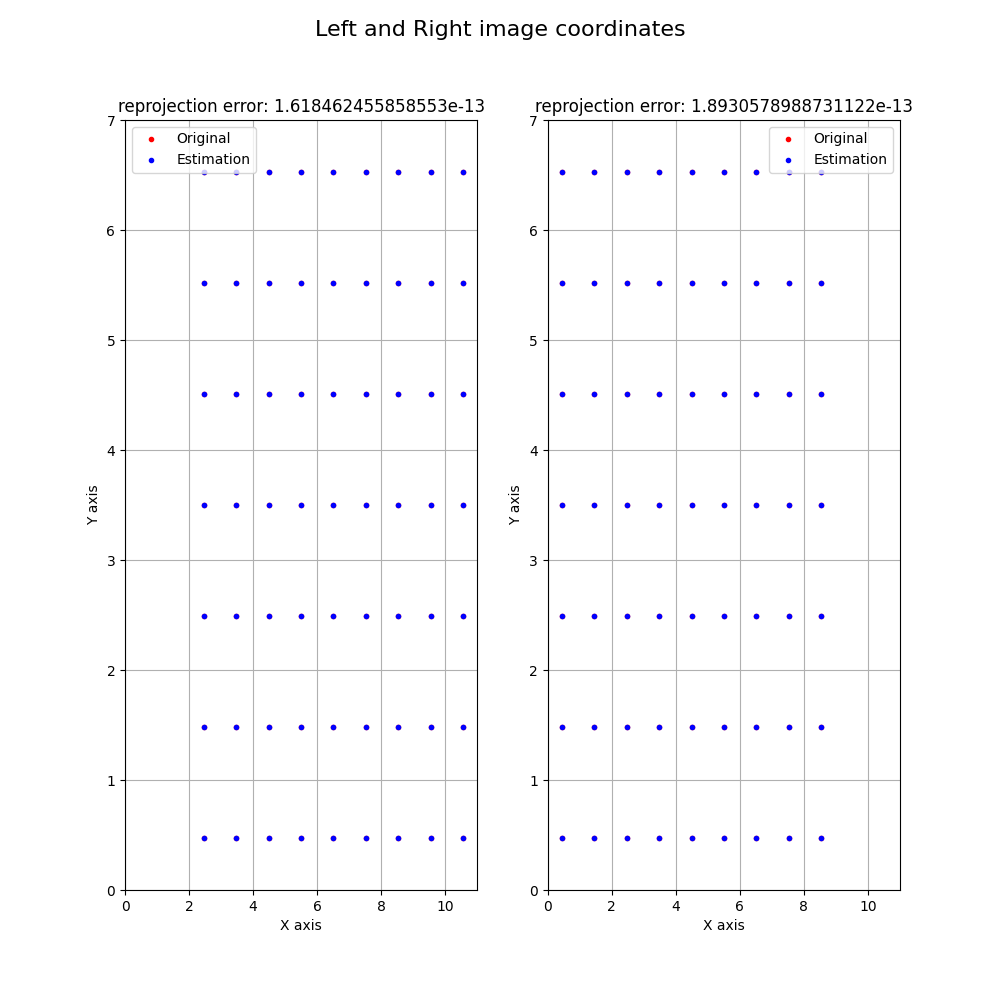

In [8]:
fig = plt.figure(figsize=(10,10))
fig.suptitle('Left and Right image coordinates', fontsize=16)
ax_L = fig.add_subplot(121)
ax_L.plot(x_arr_L[:,0],x_arr_L[:,1], color = 'r',ls = "None", marker = ".", label = 'Original')
ax_L.set_title("reprojection error: " + str(err_list_L))
ax_L.set_xlabel("X axis")
ax_L.set_ylabel("Y axis")
ax_L.grid()
ax_L.plot(xEst_L[:,0],xEst_L[:,1], color = 'b',ls = "None", marker = ".", label = 'Estimation')
ax_L.legend()
ax_L.set_xlim([0,image_size[0]])
ax_L.set_ylim([0,image_size[1]])

ax_R = fig.add_subplot(122)
ax_R.plot(x_arr_R[:,0],x_arr_R[:,1], color = 'r',ls = "None", marker = ".", label = 'Original')
ax_R.set_title("reprojection error: " + str(err_list_R))
ax_R.set_xlabel("X axis")
ax_R.set_ylabel("Y axis")
ax_R.grid()
ax_R.plot(xEst_R[:,0],xEst_R[:,1], color = 'b',ls = "None", marker = ".", label = 'Estimation')
ax_R.legend()
ax_R.set_xlim([0,image_size[0]])
ax_R.set_ylim([0,image_size[1]])
plt.show()

In [9]:
world_origin = np.zeros(3)
dx, dy, dz = np.eye(3)

world_frame = ReferenceFrame(
    origin=world_origin, 
    dx=dx, 
    dy=dy,
    dz=dz,
    name="World",
)
camera_frameL = ReferenceFrame(
    origin=C_L, 
    dx=E_L[:,:3] @ dx, 
    dy=E_L[:,:3] @ dy,
    dz=E_L[:,:3] @ dz,
    name="Camera 1 ",
)
camera_frameR = ReferenceFrame(
    origin=C_R, 
    dx=E_R[:,:3] @ dx, 
    dy=E_R[:,:3] @ dy,
    dz=E_R[:,:3] @ dz,
    name="Camera 2",
)

Z_L = PrincipalAxis(
    camera_center=camera_frameL.origin,
    camera_dz=camera_frameL.dz,
    f=F,
)
Z_R = PrincipalAxis(
    camera_center=camera_frameR.origin,
    camera_dz=camera_frameR.dz,
    f=F,
)
image_frameL = ReferenceFrame(
    origin=Z_L.p - camera_frameL.dx * PX - camera_frameL.dy * PY, 
    dx=E_L[:,:3] @ dx, 
    dy=E_L[:,:3] @ dy,
    dz=E_L[:,:3] @ dz,
    name="Image",
)
image_frameR = ReferenceFrame(
    origin=Z_R.p - camera_frameR.dx * PX - camera_frameR.dy * PY, 
    dx=E_R[:,:3] @ dx, 
    dy=E_R[:,:3] @ dy,
    dz=E_R[:,:3] @ dz,
    name="Image",
)
image_planeL = ImagePlane(
    origin=image_frameL.origin, 
    dx=image_frameL.dx, 
    dy=image_frameL.dy, 
    heigth=IMAGE_HEIGTH,
    width=IMAGE_WIDTH,
)
image_planeR = ImagePlane(
    origin=image_frameR.origin, 
    dx=image_frameR.dx, 
    dy=image_frameR.dy, 
    heigth=IMAGE_HEIGTH,
    width=IMAGE_WIDTH,
)

In [10]:
def get_plot_x(X,C,image_frame):
    #X = np.array([[6, 2,5],[6,4,5]])                        # Create a random point
    x = []
    G = []
    L = []
    pi = []

    for i in range(X.shape[0]):
        G.append(GenericPoint(X[i], name="X"))                   
        L.append(get_plucker_matrix(C, X[i]))
        X1 = image_frame.origin
        X2 = X1 + image_frame.dx
        X3 = X1 + image_frame.dy
        pi.append(get_plane_from_three_points(X1, X2, X3))
        x.append(to_inhomogeneous(L[i] @ pi[i]))

    x_arr = np.array(x)

    return x_arr, G, L,pi

In [11]:
x_arr_L,G_L,L_L,pi_L = get_plot_x(X,C_L,image_frameL)
x_arr_R,G_R,L_R,pi_R = get_plot_x(X,C_R,image_frameR)

xL = image_planeL.frame_pts()
xR = image_planeR.frame_pts()

<IPython.core.display.Javascript object>


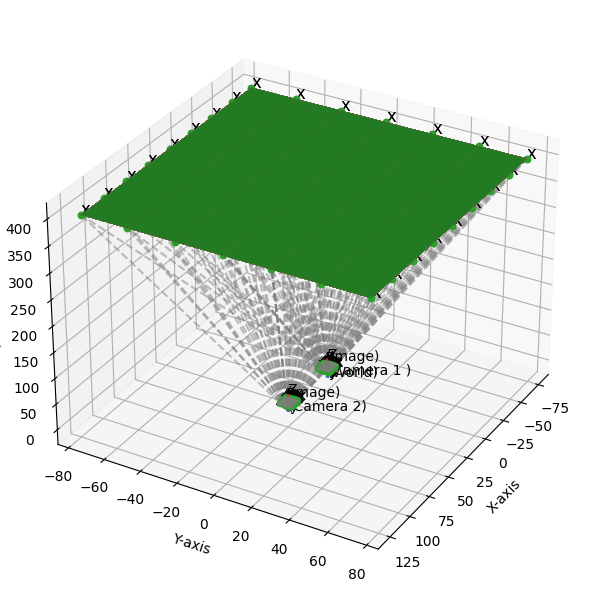

In [12]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection="3d")
ax.text(*C_L, "C")
world_frame.draw3d()
camera_frameL.draw3d()
camera_frameR.draw3d()
image_frameL.draw3d()
image_frameR.draw3d()
Z_L.draw3d()
Z_R.draw3d()
image_planeL.draw3d()
image_planeR.draw3d()
for i in range(len(G_R)):
    G_L[i].draw3d(pi_L[i], C=C_L)
    G_R[i].draw3d(pi_R[i], C=C_R)
    x_surface, y_surface, z_surface = get_plane(X,chess_dimx,chess_dimy)
    ax.plot_surface(x_surface,y_surface,z_surface)

ax.view_init(elev=30.0, azim=30.0)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>


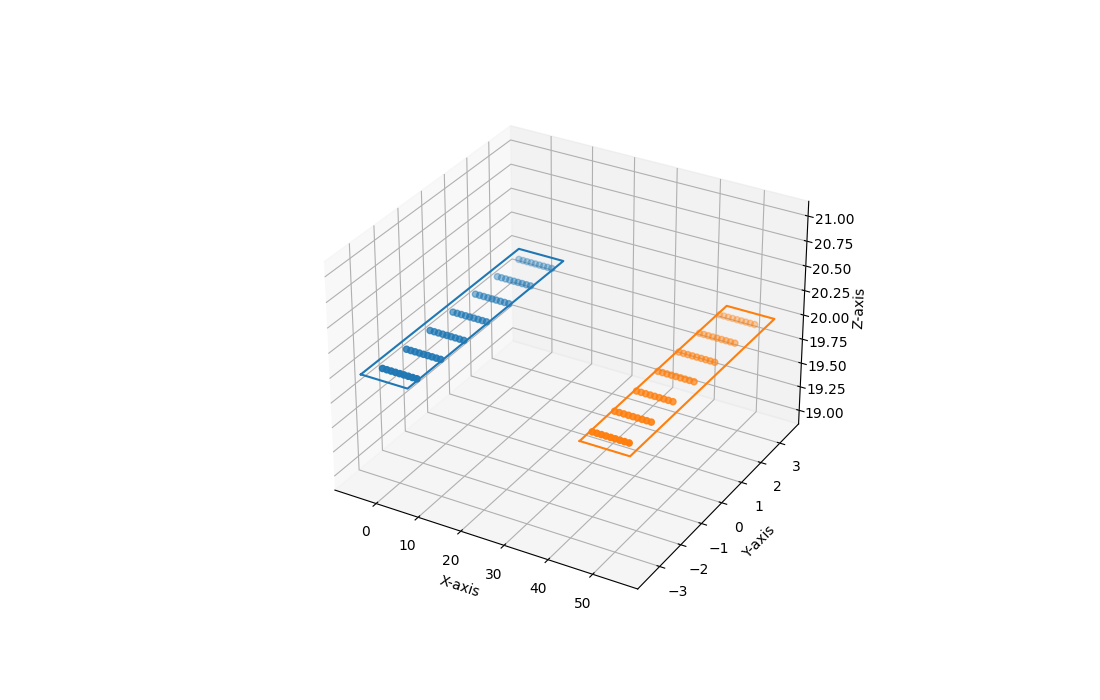

In [13]:
fig = plt.figure(figsize=(11,7))
axs = fig.add_subplot( projection = '3d')
axs.plot(xL[0,:],xL[1,:],xL[2,:])
axs.scatter3D(x_arr_L[:,0],x_arr_L[:,1],x_arr_L[:,2])
axs.plot(xR[0,:],xR[1,:],xR[2,:])
axs.scatter3D(x_arr_R[:,0],x_arr_R[:,1],x_arr_R[:,2])
axs.set_xlabel("X-axis")
axs.set_ylabel("Y-axis")
axs.set_zlabel("Z-axis")
plt.show()

In [14]:
def triangle_area(x1,y1,x2,y2,x3,y3):
    Triange_Area = abs((0.5)*(x1*(y2-y3)+x2*(y3-y1)+x3*(y1-y2)))

    return Triange_Area

def rectangle_area(x1,y1,x2,y2,x3,y3):
    xDiff = abs(x1 - x2) # Using absolute value to ignore negatives
    yDiff = abs(y2 - y3)

    area = xDiff * yDiff

    return area

In [15]:
def coord_in_imageplane(xL,M):
    A = np.array([xL[0,0],xL[1,0]])
    B = np.array([xL[0,1],xL[1,1]])
    C = np.array([xL[0,2],xL[1,2]])
    D = np.array([xL[0,3],xL[1,3]])

    M = np.array([M[0], M[1]]) 
    areaAMD = triangle_area(A[0],A[1],M[0],M[1],D[0],D[1])
    areaDPC = triangle_area(D[0],D[1],M[0],M[1],C[0],C[1])
    areaCMB = triangle_area(C[0],C[1],M[0],M[1],B[0],B[1])
    areaMBA = triangle_area(M[0],M[1],B[0],B[1],A[0],A[1])

    triangle_sum = areaAMD + areaDPC + areaCMB + areaMBA

    area_rectangle = rectangle_area(A[0],A[1],B[0],B[1],C[0],C[1])
    if(round(triangle_sum,2) > area_rectangle):
        #print("The point" + str(M) + " is out of the rectangle.")
        point = 1
    else:
        point = 0
    return point

In [16]:
points_lostL = 0
points_lostR = 0
for i in range(x_arr_L.shape[0]):
    if(coord_in_imageplane(xL,x_arr_L[i,:]) == 1):
        points_lostL += 1
for i in range(x_arr_R.shape[0]):
    if(coord_in_imageplane(xR,x_arr_R[i,:]) == 1):
        points_lostR += 1


In [17]:
points_lostR

0

In [18]:
points_lostL

0

## Multiple chessboards

In [ ]:
translst= []
L_camera = []
L_camera_optimal = []
R_camera = []
R_camera_optimal = []
stereo_camera =[]

zrange = ([700,1000,1500,2000])
for i in range(len(zrange)):
    for z in zrange[:i+1]:
        for x in range(-500,500,100):
            for y in range(-500,500,100):
                translst.append([x,y,z])

    len(translst)

    # chessboard print
    chess_pts = []
    world_pts = create_chessboard(chess_dimx,chess_dimy,chess_sq_size)
    rotangles = [[0,0,0],[np.pi/3,0,-np.pi/2],[np.pi/3,0,np.pi/2],[0,np.pi/3,np.pi/2],[0,-np.pi/3,np.pi/2]]

    for i in range(len(translst)):
        for j in range(len(rotangles)):    
            chess_pts.append(get_chessboard_rot_trans(world_pts,rotangles[j][0],rotangles[j][1],rotangles[j][2],translst[i][0],translst[i][1],translst[i][2]))

    chess_pts_arr = np.array(chess_pts)
    
    ###
    x_lst_R = []
    x_lst_L = []
    for i in range(chess_pts_arr.shape[0]):
        x_arr_R, X_arr_R, E_R = get_image_points(chess_pts_arr[i,:,:],PX,PY,thetax= 0.0,thetay = 0.0,thetaz = 0.0,trans_x= -C_R[0],trans_y= -C_R[1],trans_z= -C_R[2],F = F)
        x_arr_L, X_arr_L, E_L = get_image_points(chess_pts_arr[i,:,:],PX,PY,thetax= 0.0,thetay = 0.0,thetaz = 0.0,trans_x= -C_L[0],trans_y= -C_L[1],trans_z= -C_L[2],F = F)

        x_lst_R.append(x_arr_R)
        x_lst_L.append(x_arr_L)

    x_zhang_R = np.array(x_lst_R,np.float32)
    x_zhang_L = np.array(x_lst_L,np.float32)

    ####
    pattern_size_x,pattern_size_y = (chess_dimx,chess_dimy)

    X = np.linspace(0, pattern_size_x,pattern_size_x + 1)
    Y = np.linspace(0, pattern_size_y,pattern_size_y + 1)

    zdata = np.zeros((pattern_size_x + 1,pattern_size_y + 1))
    xdata, ydata = np.meshgrid(X, Y)

    xdata_ = xdata.flatten()
    ydata_ = ydata.flatten()
    zdata_ = zdata.flatten()
    # homogeneous coordinates
    world_pts =([xdata_,ydata_,zdata_])
    world_pts_ = np.array(world_pts).T

    world_pts_arr = np.zeros((chess_pts_arr.shape[0],(pattern_size_x+1)*(pattern_size_y+1),3),np.float32)
    for i in range(chess_pts_arr.shape[0]):
        world_pts_arr[i,:,:] = world_pts_

    world_pts_arr = world_pts_arr.reshape(world_pts_arr.shape[0],1,(pattern_size_x+1)*(pattern_size_y+1),3)
    world_pts_arr.shape
    
    #####
    print("calibrate R")
    ret_R, mtx_R, dist_R, rvecs_R, tvecs_R = cv2.calibrateCamera(world_pts_arr, x_zhang_R, (image_size[0],image_size[1]), None, None)
    R_camera.append([ret_R, mtx_R, dist_R, rvecs_R, tvecs_R])
    # Returns the new camera intrinsic matrix based on the free scaling parameter
    new_mtx_R = cv2.getOptimalNewCameraMatrix(mtx_R,dist_R,(image_size[0],image_size[1]),1,(image_size[0],image_size[1]))
    R_camera_optimal.append(new_mtx_R)
    #####
    print("calibrate L")
    ret_L, mtx_L, dist_L, rvecs_L, tvecs_L = cv2.calibrateCamera(world_pts_arr, x_zhang_L, (image_size[0],image_size[1]), None, None)
    L_camera.append([ret_L, mtx_L, dist_L, rvecs_L, tvecs_L])
    # Returns the new camera intrinsic matrix based on the free scaling parameter
    new_mtx_L = cv2.getOptimalNewCameraMatrix(mtx_L,dist_L,(image_size[0],image_size[1]),1,(image_size[0],image_size[1]))
    L_camera_optimal.append(new_mtx_L)
    
    ####
    flags = 0
    flags |= cv2.CALIB_FIX_INTRINSIC
    # Here we fix the intrinsic camara matrixes so that only Rot, Trns, Emat and Fmat are calculated.
    # Hence intrinsic parameters are the same 

    criteria_stereo= (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    print("calibrate stereo")
    # This step is performed to transformation between the two cameras and calculate Essential and Fundamenatl matrix
    retS, new_mtxL, distL, new_mtxR, distR, Rot, Trns, Emat, Fmat = cv2.stereoCalibrate(world_pts_arr, x_zhang_L, x_zhang_R, new_mtx_L[0], dist_L, new_mtx_R[0], dist_R, (image_size[0],image_size[1]), criteria_stereo, flags)
    stereo_camera.append([retS, new_mtxL, distL, new_mtxR, distR, Rot, Trns, Emat, Fmat])
    print(retS)
    print("end")

In [21]:
translst= []

zrange = ([1000,1500,2000])
for z in zrange:
    for x in range(-1000,1000,200):
        for y in range(-1000,1000,200):
            translst.append([x,y,z])
            
len(translst)

300

In [22]:
# chessboard print
chess_pts = []
world_pts = create_chessboard(chess_dimx,chess_dimy,chess_sq_size)
rotangles = [[0,0,0],[np.pi/3,0,-np.pi/2],[np.pi/3,0,np.pi/2],[0,np.pi/3,np.pi/2],[0,-np.pi/3,np.pi/2]]

for i in range(len(translst)):
    for j in range(len(rotangles)):    
        chess_pts.append(get_chessboard_rot_trans(world_pts,rotangles[j][0],rotangles[j][1],rotangles[j][2],translst[i][0],translst[i][1],translst[i][2]))

chess_pts_arr = np.array(chess_pts)

chess_pts_arr.shape

(1500, 63, 3)

<IPython.core.display.Javascript object>


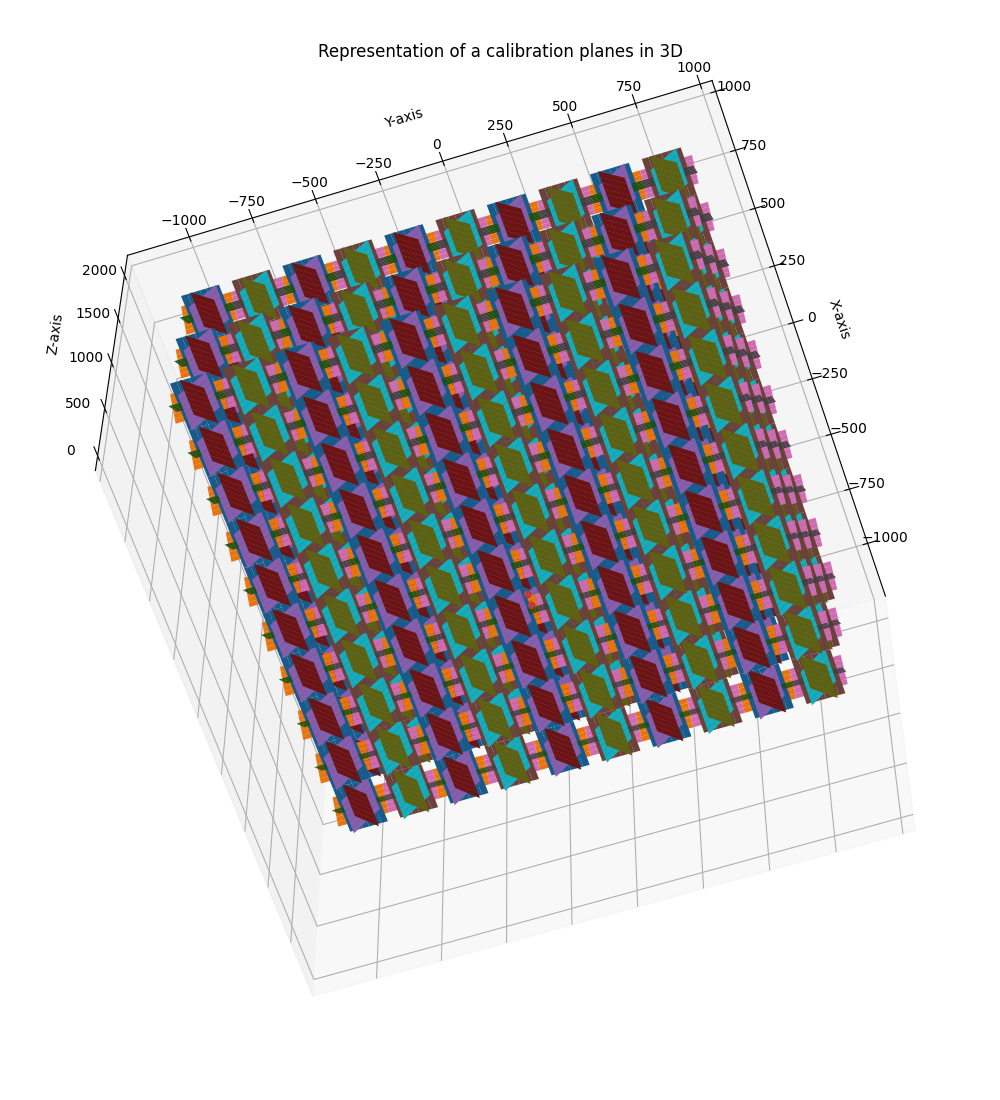

In [23]:
fig = plt.figure(figsize=(10, 11))
ax = fig.add_subplot(projection="3d")
ax.text(*C_L, "C")
world_frame.draw3d()
camera_frameL.draw3d()
camera_frameR.draw3d()
image_frameL.draw3d()
image_frameR.draw3d()
Z_L.draw3d()
Z_R.draw3d()
image_planeL.draw3d()
image_planeR.draw3d()

for i in range(chess_pts_arr.shape[0]):
    x_surface, y_surface, z_surface = get_plane(chess_pts_arr[i,:,:],chess_dimx,chess_dimy)
    #print(x_surface)
    ax.plot_surface(x_surface,y_surface,z_surface)

ax.view_init(elev=30.0, azim=30.0)

ax.set_title(f"Representation of a calibration planes in 3D")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.tight_layout()
plt.show()

### Get the homographies of the different chessboards

In [24]:
x_lst_R = []
x_lst_L = []
for i in range(chess_pts_arr.shape[0]):
    x_arr_R, X_arr_R, E_R = get_image_points(chess_pts_arr[i,:,:],PX,PY,thetax= 0.0,thetay = 0.0,thetaz = 0.0,trans_x= -C_R[0],trans_y= -C_R[1],trans_z= -C_R[2],F = F)
    x_arr_L, X_arr_L, E_L = get_image_points(chess_pts_arr[i,:,:],PX,PY,thetax= 0.0,thetay = 0.0,thetaz = 0.0,trans_x= -C_L[0],trans_y= -C_L[1],trans_z= -C_L[2],F = F)
    
    x_lst_R.append(x_arr_R)
    x_lst_L.append(x_arr_L)

x_zhang_R = np.array(x_lst_R,np.float32)
x_zhang_L = np.array(x_lst_L,np.float32)
print(x_zhang_R.shape)
print(x_zhang_L.shape)

(1500, 63, 2)
(1500, 63, 2)


In [25]:
#
#xL = image_planeL.frame_pts()
#xR = image_planeR.frame_pts()
#for i in range(chess_pts_arr.shape[0]):
#    
#    x_arr_L,G_L,L_L,pi_L = get_plot_x(chess_pts_arr[i,:,:],C_L,image_frameL)
#    x_arr_R,G_R,L_R,pi_R = get_plot_x(chess_pts_arr[i,:,:],C_R,image_frameR)
#    
#    for j in range(x_arr_L.shape[0]):
#        if(coord_in_imageplane(xL,x_arr_L[j,:]) == 1):
#            print("discard" + str(i) +"homography")
#            break
#    for j in range(x_arr_R.shape[0]):
#        if(coord_in_imageplane(xR,x_arr_R[j,:]) == 1):
#            print("discard" + str(i) +"homography")
#            break
#

In [26]:
pattern_size_x,pattern_size_y = (chess_dimx,chess_dimy)

X = np.linspace(0, pattern_size_x,pattern_size_x + 1)
Y = np.linspace(0, pattern_size_y,pattern_size_y + 1)

zdata = np.zeros((pattern_size_x + 1,pattern_size_y + 1))
xdata, ydata = np.meshgrid(X, Y)

xdata_ = xdata.flatten()
ydata_ = ydata.flatten()
zdata_ = zdata.flatten()
# homogeneous coordinates
world_pts =([xdata_,ydata_,zdata_])
world_pts_ = np.array(world_pts).T

world_pts_arr = np.zeros((chess_pts_arr.shape[0],(pattern_size_x+1)*(pattern_size_y+1),3),np.float32)
for i in range(chess_pts_arr.shape[0]):
    world_pts_arr[i,:,:] = world_pts_

world_pts_arr = world_pts_arr.reshape(world_pts_arr.shape[0],1,(pattern_size_x+1)*(pattern_size_y+1),3)
world_pts_arr.shape

(1500, 1, 63, 3)

In [27]:
#fig = plt.figure(figsize=(11,7))
#ax = fig.add_subplot(121)
#ax.scatter(x_zhang_R[0,:,0],x_zhang_R[0,:,1])
#ax = fig.add_subplot(122)
#ax.scatter(x_zhang_L[0,:,0],x_zhang_L[0,:,1])
#plt.show()

In [ ]:
ret_R, mtx_R, dist_R, rvecs_R, tvecs_R = cv2.calibrateCamera(world_pts_arr, x_zhang_R, (image_size[0],image_size[1]), None, None)
# Returns the new camera intrinsic matrix based on the free scaling parameter
new_mtx_R = cv2.getOptimalNewCameraMatrix(mtx_R,dist_R,(image_size[0],image_size[1]),1,(image_size[0],image_size[1]))

In [ ]:
ret_L, mtx_L, dist_L, rvecs_L, tvecs_L = cv2.calibrateCamera(world_pts_arr, x_zhang_L, (image_size[0],image_size[1]), None, None)
# Returns the new camera intrinsic matrix based on the free scaling parameter
new_mtx_L = cv2.getOptimalNewCameraMatrix(mtx_L,dist_L,(image_size[0],image_size[1]),1,(image_size[0],image_size[1]))

In [ ]:
flags = 0
flags |= cv2.CALIB_FIX_INTRINSIC
# Here we fix the intrinsic camara matrixes so that only Rot, Trns, Emat and Fmat are calculated.
# Hence intrinsic parameters are the same 

criteria_stereo= (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


# This step is performed to transformation between the two cameras and calculate Essential and Fundamenatl matrix
retS, new_mtxL, distL, new_mtxR, distR, Rot, Trns, Emat, Fmat = cv2.stereoCalibrate(world_pts_arr, x_zhang_L, x_zhang_R, new_mtx_L[0], dist_L, new_mtx_R[0], dist_R, (image_size[0],image_size[1]), criteria_stereo, flags)


In [ ]:
L_camera = []
L_camera_optimal = []
R_camera = []
R_camera_optimal = []
stereo_camera =[]

In [ ]:
R_camera.append([ret_R, mtx_R, dist_R, rvecs_R, tvecs_R])
R_camera.append([ret_L, mtx_L, dist_L, rvecs_L, tvecs_L])

In [ ]:
R_camera_arr = np.array(R_camera)

In [ ]:
R_camera_arr.shape

In [ ]:
L_camera_optimal.append(new_mtx_L])

In [ ]:
L_camera_optimal